In [309]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [310]:
df = pd.read_csv('12_accept.csv')

In [311]:
share_1 = (df['target'] == 1).sum()/(df['target']==0).sum() * 100
print(f'Доля значений 1 в выборке accept: {share_1:.3}%')

Доля значений 1 в выборке accept: 2.19%


### EDA

In [312]:
df.drop('UID', axis=1, inplace=True)

In [313]:
cat = ['INCOME_TYPE', 'EDUCATION_', 'CUSTOMER_CATEGORY_', 'IS_EMPL']

In [314]:
num = ['income', 'COUNT_ACTIVE_CREDIT_NO_CC', 'CNT_MNTH_FROM_LAST_PMNT', 'age', 'experience', 'count_mnth_act_passport',
      'DEPENDANT_NUMBER', 'inquiry_14_day', 'inquiry_21_day']

In [315]:
df_means = pd.DataFrame()
for col in num:
    median = np.round(df[col].median(), 2)
    mean = np.round(df[col].mean(), 2)
    nans = df[col].isna().sum()
    var = df[col].var()
    df_means = df_means.append([[col, median, mean, nans, var]])
df_means.columns = ['var_name', 'median', 'mean', 'nan_count', 'var']
df_means.reset_index(drop=True, inplace=True)

In [316]:
df_means

,var_name,median,mean,nan_count,var
0,income,41412.00,61565.71,659,1.105261e+10
1,COUNT_ACTIVE_CREDIT_NO_CC,0.00,0.66,8313,6.768854e-01
2,CNT_MNTH_FROM_LAST_PMNT,0.93,18.74,10077,1.763151e+04
3,age,34.78,36.49,0,6.745987e+01
4,experience,3.29,4.94,41,2.840619e+01
5,count_mnth_act_passport,7.76,7.22,0,1.117284e+01
6,DEPENDANT_NUMBER,0.00,0.01,33,1.095505e-02
7,inquiry_14_day,0.00,0.36,9126,3.684496e-01
8,inquiry_21_day,0.00,0.42,9126,4.655744e-01


In [317]:
df_cat = pd.DataFrame()
for col in cat:
    mode = df[col].value_counts().index[0]
    nans = df[col].isna().sum()
    df_cat = df_cat.append([[col, mode, nans]])
df_cat.columns = ['var_name', 'mode',  'nan_count']
df_cat.reset_index(drop=True, inplace=True)

In [318]:
df_cat

,var_name,mode,nan_count
0,INCOME_TYPE,OTHER,0
1,EDUCATION_,elementary,0
2,CUSTOMER_CATEGORY_,Corporate,19363
3,IS_EMPL,0,0


### Outliers

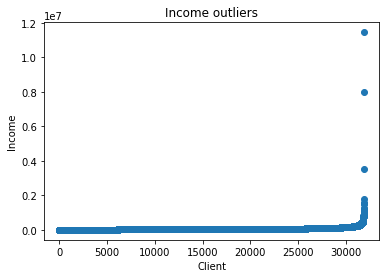

In [319]:
plt.scatter(np.arange(len(df)), df['income'].sort_values())
plt.title('Income outliers')
plt.ylabel('Income')
plt.xlabel('Client')
plt.show()

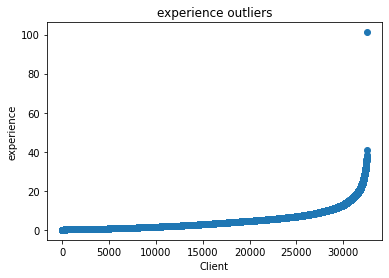

In [320]:
plt.scatter(np.arange(len(df)), df['experience'].sort_values())
plt.title('experience outliers')
plt.ylabel('experience')
plt.xlabel('Client')
plt.show()

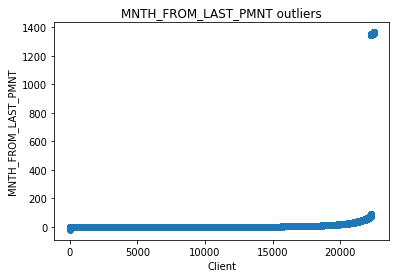

In [321]:
plt.scatter(np.arange(len(df)), df['CNT_MNTH_FROM_LAST_PMNT'].sort_values())
plt.title('MNTH_FROM_LAST_PMNT outliers')
plt.ylabel('MNTH_FROM_LAST_PMNT')
plt.xlabel('Client')
plt.show()

In [322]:
df.loc[df['income'].nlargest(3).index, 'income'] = df['income'].nlargest(4).values[-1]

In [323]:
df.loc[df['experience'].nlargest(1).index, 'experience'] = df['experience'].nlargest(2).values[-1]

In [324]:
df.loc[df['CNT_MNTH_FROM_LAST_PMNT'].nlargest(218).index, 'CNT_MNTH_FROM_LAST_PMNT'] = df['CNT_MNTH_FROM_LAST_PMNT'].nlargest(219).values[-1]

Для признака CUSTOMER_CATEGORY_ пропущенные значения очевидно означают отсутствие у клиента значения признака corporate/vip, заполним пропущенные значения значением "Normal"

In [325]:
df['CUSTOMER_CATEGORY_'] = df['CUSTOMER_CATEGORY_'].fillna('Normal')

### WoE, IV

In [326]:
from sklearn.preprocessing import LabelEncoder

In [327]:
total_1 = df['target'].sum()
total_0 = len(df) - total_1

In [328]:
def check_monotonic(arr):
    return (all(arr[i] <= arr[i + 1] for i in range(len(arr)-1))
            or all(arr[i] >= arr[i + 1] for i in range(len(arr)-1)))

In [329]:
def find_bins(df, col, total_1, total_0, force_num=False):
    success = False
    if force_num:
        df[f'{col}_cut'] = pd.cut(df.fillna(0)[col], force_num)
        df_gr = df.groupby(f'{col}_cut').agg({'target':['count', 'sum']})
        df_gr['woe'] = np.log((df_gr['target']['sum']/total_1)/((df_gr['target']['count'] - df_gr['target']['sum']
                                                                )/total_0))        
        if check_monotonic(df_gr['woe'].values):
            success=True
    else:
        for n_bins in np.arange(20, 2, -1):
            df[f'{col}_cut'] = pd.qcut(df[col], n_bins, duplicates='drop')
            df_gr = df.groupby(f'{col}_cut').agg({'target':['count', 'sum']})
            df_gr['woe'] = np.log((df_gr['target']['sum']/total_1)/((df_gr['target']['count'] - df_gr['target']['sum']
                                                                    )/total_0))        
            if check_monotonic(df_gr['woe'].values):
                success=True
                break
    return success, df_gr

In [330]:
def cut_df(df, col, total_1, total_0, num_bins, verbose=False):
    success=False
    df[f'{col}_cut'] = pd.cut(df[col], num_bins).apply(lambda x:x.right)
    df_gr = df.groupby(f'{col}_cut').agg({'target':['count', 'sum']})
    df_gr['woe'] = np.log((df_gr['target']['sum']/total_1)/((df_gr['target']['count'] - df_gr['target']['sum']
                                                            )/total_0))        
    if check_monotonic(df_gr['woe'].values):
        success=True
    if verbose:           
        return success, df_gr

In [331]:
def qcut_df(df, col, total_1, total_0, num_bins):
    success=False
    df[f'{col}_cut'] = pd.qcut(df[col], num_bins)
    df_gr = df.groupby(f'{col}_cut').agg({'target':['count', 'sum']})
    df_gr['woe'] = np.log((df_gr['target']['sum']/total_1)/((df_gr['target']['count'] - df_gr['target']['sum']
                                                            )/total_0))        
    if check_monotonic(df_gr['woe'].values):
        success=True
                
    return success, df_gr

In [332]:
def get_woe(df, col_cut, total_1, total_0):
    df_gr = df.groupby(f'{col_cut}').agg({'target':['count', 'sum']})
    df_gr['woe'] = np.log((df_gr['target']['sum']/total_1)/((df_gr['target']['count'] - df_gr['target']['sum']
                                                            )/total_0))    
    return df_gr

In [333]:
def iv(df, split_column, total_1, total_0):
    df_gr = df.groupby(split_column).agg({'target':['count', 'sum']})
    df_gr['good'] =df_gr['target']['count'] - df_gr['target']['sum']
    df_gr['bad'] = df_gr['target']['sum']
    df_gr['woe'] = np.log((df_gr['bad']/total_1)/(df_gr['good']/total_0)) 
    iv = 0
    return ((df_gr['bad']/total_1-df_gr['good']/total_0) * df_gr['woe']).sum()

In [334]:
#bins for income + NaN group
bins_income = [-0.001,
        18949.2,
 24786.8,
 29885.2,
 41412.0,
 60133.2,
 120000.0,
 1784679.0]

#experience: quantile split with 7 groups + NaN group
#DEPENDANT_NUMBER: group for 0, group for all else, group for nans
#INCOME_TYPE: OK groups by value
#EDUCATION_: reorder: beginner, elementary, advanced, high
#CUSTOMER_CATEGORY_: reorder: Corporate + VIP, normal
#IS_EMPL: 2 values already

#bins for age
bins_age = [24.999,
 27.781,
 29.568,
 31.449,
 33.622,
 34.783,
 #40.553,
 44.373,
 58.938]

#bins for COUNT_ACTIVE_CREDIT_NO_CC - можно позволить сделать группы большего размера без потери информации
bins_active = [-0.1,
              0.9,
              1.9,
              8]

#CNT_MNTH_FROM_LAST_PMNT - работает разбивкой на 5 квантилей, но дает странные результаты (чем больше, тем меньше дефолтов)
#inquiry_14_day - две группы, 0 и все остальное + для nan 
#inquiry_21_day - имеет смысл на 3: 0, 1 и все остальное + для nan

#bins for passport - не очень монотонно, но лучше не получится
bins_pas = [-0.1,
 1.998,
 3.126,
 4.139,
 6.03,
 6.618,
 7.758,
 9.559,
 10.23,
 15.806]

In [335]:
encoder = LabelEncoder()

In [336]:
def cut_df_train(df):
    df['income_cut'] = pd.cut(df['income'], bins_income).apply(lambda x:x.right).astype(int)
    df['income_cut'].fillna('No', inplace=True)
    df['income_cut'] = encoder.fit_transform(df['income_cut'])
    df['income_cut'] = df['income_cut'].replace([0,1,2,3,4,5,6,7], [0,7,6,4,3,1,2,5])

    df['EDUCATION_cut'] = df['EDUCATION_'].replace(['elementary', 'beginner', 'advanced', 'high'],
                                                   [1, 0, 2, 3])

    df['INCOME_TYPE_cut'] = df['INCOME_TYPE'].replace(['OTHER', '2NDFL'], [0,1])

    df['CUSTOMER_CATEGORY_cut'] = df['CUSTOMER_CATEGORY_'].replace(['Normal', 'Corporate', 'VIP'], [0,1,1])

    df['DEPENDANT_NUMBER_cut'] =  (df['DEPENDANT_NUMBER'] == 0).astype(int) + df['DEPENDANT_NUMBER'].isna().astype(int) * 2

    df['IS_EMPL_cut'] = df['IS_EMPL']

    df['COUNT_ACTIVE_CREDIT_NO_CC_cut'] = pd.cut(df['COUNT_ACTIVE_CREDIT_NO_CC'], bins_active).apply(lambda x:x.right).astype(int)
    df['COUNT_ACTIVE_CREDIT_NO_CC_cut'].fillna('No', inplace=True)
    df['COUNT_ACTIVE_CREDIT_NO_CC_cut'] = encoder.fit_transform(df['COUNT_ACTIVE_CREDIT_NO_CC_cut'])
    df['COUNT_ACTIVE_CREDIT_NO_CC_cut'] = df['COUNT_ACTIVE_CREDIT_NO_CC_cut'].replace([0,1,2,3], [2,0,1,3])

    df['CNT_MNTH_FROM_LAST_PMNT_cut'] = pd.qcut(df['CNT_MNTH_FROM_LAST_PMNT'], 5).apply(lambda x:x.right).astype(str)
    bins_cnt = [df['CNT_MNTH_FROM_LAST_PMNT'].min() - 1]
    for bin_ in df['CNT_MNTH_FROM_LAST_PMNT_cut'].unique():
        bins_cnt.append(bin_)
    df['CNT_MNTH_FROM_LAST_PMNT_cut'].fillna('No', inplace=True)
    df['CNT_MNTH_FROM_LAST_PMNT_cut'] = encoder.fit_transform(df['CNT_MNTH_FROM_LAST_PMNT_cut'])

    df['age_cut'] = pd.cut(df['age'], bins_age).apply(lambda x:x.right).astype(int)
    df['age_cut'].fillna('No', inplace=True)
    df['age_cut'] = encoder.fit_transform(df['age_cut'])
    df['age_cut'] = df['age_cut'].replace([0,1,2,3,4,5,6], [1,3,5,6,4,2,0])

    df['experience_cut'] = pd.qcut(df['experience'], 7).apply(lambda x:x.right).astype(str)
    bins_exp = [-0.1]
    for bin_ in df['experience_cut'].unique():
        bins_exp.append(bin_)
    df['experience_cut'].fillna('No', inplace=True)
    df['experience_cut'] = encoder.fit_transform(df['experience_cut'])

    df['inquiry_14_day_cut'] = ((df['inquiry_14_day'] > 0) & 
                                (df['inquiry_14_day'].notna()))*2 + df['inquiry_14_day'].isna()*1

    df['inquiry_21_day_cut'] = (df['inquiry_21_day'] == 1) * 1 + (df['inquiry_21_day'] > 1) * 3 + df['inquiry_21_day'].isna()*2

    df['count_mnth_act_passport_cut'] = pd.cut(df['count_mnth_act_passport'], bins_pas).apply(lambda x:x.right).astype(int)
    df['count_mnth_act_passport_cut'].fillna('No', inplace=True)
    df['count_mnth_act_passport_cut']= encoder.fit_transform(df['count_mnth_act_passport_cut'])
    df['count_mnth_act_passport_cut'] = df['count_mnth_act_passport_cut'].replace([0,1,2,3,4,5,6,7], [0,1,2,3,6,7,5,4])
    
    for col in df.columns:
        if '_cut' in col:
            df_gr = get_woe(df, col, total_1, total_0)
            df[f'{col}_woe'] = df[col].replace(sorted(df[col].unique()), df_gr['woe'].values)
            
    return [df, np.array(bins_exp), np.array(bins_cnt)]

In [337]:
def cut_df_test(df, df_train):
    df['income_cut'] = pd.cut(df['income'], bins_income).apply(lambda x:x.right).astype(int)
    df['income_cut'].fillna('No', inplace=True)
    df['income_cut'] = encoder.fit_transform(df['income_cut'])
    df['income_cut'] = df['income_cut'].replace([0,1,2,3,4,5,6,7], [0,7,6,4,3,1,2,5])

    df['EDUCATION_cut'] = df['EDUCATION_'].replace(['elementary', 'beginner', 'advanced', 'high'],
                                                   [1, 0, 2, 3])

    df['INCOME_TYPE_cut'] = df['INCOME_TYPE'].replace(['OTHER', '2NDFL'], [0,1])

    df['CUSTOMER_CATEGORY_cut'] = df['CUSTOMER_CATEGORY_'].replace(['Normal', 'Corporate', 'VIP'], [0,1,1])

    df['DEPENDANT_NUMBER_cut'] =  (df['DEPENDANT_NUMBER'] == 0).astype(int) + df['DEPENDANT_NUMBER'].isna().astype(int) * 2

    df['IS_EMPL_cut'] = df['IS_EMPL']

    df['COUNT_ACTIVE_CREDIT_NO_CC_cut'] = pd.cut(df['COUNT_ACTIVE_CREDIT_NO_CC'], bins_active).apply(lambda x:x.right).astype(int)
    df['COUNT_ACTIVE_CREDIT_NO_CC_cut'].fillna('No', inplace=True)
    df['COUNT_ACTIVE_CREDIT_NO_CC_cut'] = encoder.fit_transform(df['COUNT_ACTIVE_CREDIT_NO_CC_cut'])
    df['COUNT_ACTIVE_CREDIT_NO_CC_cut'] = df['COUNT_ACTIVE_CREDIT_NO_CC_cut'].replace([0,1,2,3], [2,0,1,3])

    df['CNT_MNTH_FROM_LAST_PMNT_cut'] = pd.cut(df['CNT_MNTH_FROM_LAST_PMNT'], bins_cnt).apply(lambda x:x.right).astype(str)
    df['CNT_MNTH_FROM_LAST_PMNT_cut'].fillna('No', inplace=True)
    df['CNT_MNTH_FROM_LAST_PMNT_cut'] = encoder.fit_transform(df['CNT_MNTH_FROM_LAST_PMNT_cut'])

    df['age_cut'] = pd.cut(df['age'], bins_age).apply(lambda x:x.right).astype(int)
    df['age_cut'].fillna('No', inplace=True)
    df['age_cut'] = encoder.fit_transform(df['age_cut'])
    df['age_cut'] = df['age_cut'].replace([0,1,2,3,4,5,6], [1,3,5,6,4,2,0])

    df['experience_cut'] = pd.cut(df['experience'], bins_exp).apply(lambda x:x.right).astype(int)
    df['experience_cut'].fillna('No', inplace=True)
    df['experience_cut'] = encoder.fit_transform(df['experience_cut'])

    df['inquiry_14_day_cut'] = ((df['inquiry_14_day'] > 0) & 
                                (df['inquiry_14_day'].notna()))*2 + df['inquiry_14_day'].isna()*1

    df['inquiry_21_day_cut'] = (df['inquiry_21_day'] == 1) * 1 + (df['inquiry_21_day'] > 1) * 3 + df['inquiry_21_day'].isna()*2

    df['count_mnth_act_passport_cut'] = pd.cut(df['count_mnth_act_passport'], bins_pas).apply(lambda x:x.right).astype(int)
    df['count_mnth_act_passport_cut'].fillna('No', inplace=True)
    df['count_mnth_act_passport_cut']= encoder.fit_transform(df['count_mnth_act_passport_cut'])
    df['count_mnth_act_passport_cut'] = df['count_mnth_act_passport_cut'].replace([0,1,2,3,4,5,6,7], [0,1,2,3,6,7,5,4])
    
    for col in df.columns:
        if '_cut' in col:
            df_gr = get_woe(df_train, col, total_1, total_0)
            df[f'{col}_woe'] = df[col].replace(sorted(df[col].unique()), df_gr['woe'].loc[sorted(df[col].unique())].values)
            
    return df

In [338]:
df_1 = df

In [339]:
df, bins_exp, bins_cnt = cut_df_train(df)

In [340]:
bins_exp = sorted(bins_exp[bins_exp != 'nan'].astype(float))

In [341]:
bins_cnt =sorted(bins_cnt[bins_cnt != 'nan'].astype(float))

In [342]:
ivs = []
for col in df.columns:
    if '_cut' in col:
        ivs.append((col, iv(df, col, total_1, total_0)))

In [343]:
print(pd.DataFrame(ivs, columns=['Column', 'IV']))

                               Column        IV
0                          income_cut  0.113315
1                       EDUCATION_cut  0.040317
2                     INCOME_TYPE_cut  0.008610
3               CUSTOMER_CATEGORY_cut  0.527688
4                DEPENDANT_NUMBER_cut  0.336817
5                         IS_EMPL_cut  0.795765
6       COUNT_ACTIVE_CREDIT_NO_CC_cut  0.108360
7         CNT_MNTH_FROM_LAST_PMNT_cut  0.140995
8                             age_cut  0.023668
9                      experience_cut  0.401254
10                 inquiry_14_day_cut  0.123944
11                 inquiry_21_day_cut  0.169317
12        count_mnth_act_passport_cut  0.064875
13                     income_cut_woe  0.113315
14                  EDUCATION_cut_woe  0.040317
15                INCOME_TYPE_cut_woe  0.008610
16          CUSTOMER_CATEGORY_cut_woe  0.527688
17           DEPENDANT_NUMBER_cut_woe  0.336817
18                    IS_EMPL_cut_woe  0.795765
19  COUNT_ACTIVE_CREDIT_NO_CC_cut_woe  0

### Models

In [344]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve, roc_auc_score, plot_confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

In [345]:
to_drop = []
for col in df.columns:
    if '_woe' not in col:
        to_drop.append(col)
X = df.drop(to_drop, axis=1)
y = df['target']

In [346]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=6)

In [347]:
def gini(y, pred):
    return 2 * roc_auc_score(y, pred) - 1

In [348]:
def get_metrics(model, X, y):
    pred = model.predict_proba(X)[:,1]
    plot_roc_curve(model, X, y)
    plt.plot(np.arange(0,1,0.01), np.arange(0,1, 0.01))
    plot_confusion_matrix(model, X, y)    
    print(f'GINI: {gini(y, pred)}')
    print(f'F : {f1_score(y, model.predict(X))}')

In [349]:
lr = LogisticRegression(max_iter=2000,  class_weight='balanced')
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=2000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Метрики на тестовой выборке при обучении на обучающей выборке:

GINI: 0.6343860712456078
F : 0.09981515711645102


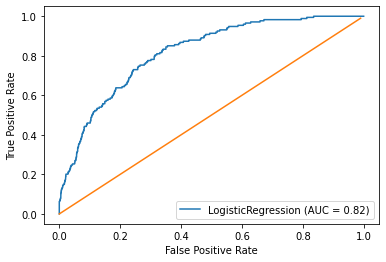

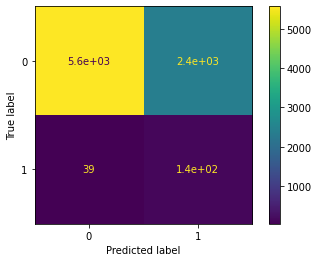

In [350]:
get_metrics(lr, X_test, y_test)

Метрики на всей выборке при обучении на всей выборке:

GINI: 0.643510236224657
F : 0.10189201661282879


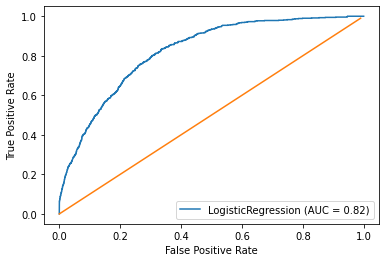

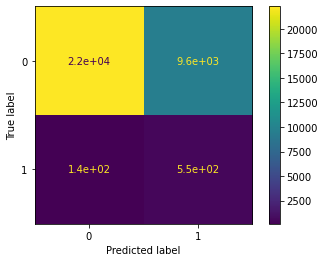

In [351]:
lr.fit(X, y)
get_metrics(lr, X, y)

### Reject interference

In [352]:
df_rej = pd.read_csv('12_reject.csv')

In [353]:
print(f'{(len(df_rej) / len(df) * 100):.3} % rejected')

32.8 % rejected


In [354]:
df_rej.drop('UID', axis=1, inplace=True)

In [355]:
df_rej['CUSTOMER_CATEGORY_'].fillna('Normal', inplace=True)

In [356]:
df_rej = cut_df_test(df_rej, df_1)

In [357]:
to_drop = []
for col in df_rej.columns:
    if '_woe' not in col:
        to_drop.append(col)
df_rej.drop(to_drop, axis=1, inplace=True)

In [358]:
df_rej['prob_rej'] = lr.predict_proba(df_rej)[:,1]

In [359]:
df['prob_acc'] = lr.predict_proba(X)[:,1]

In [360]:
df['prob_acc_cut'] = pd.cut(df['prob_acc'], 
                            [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1]).apply(lambda x:x.right).astype(float)

In [361]:
df_gr = df.groupby('prob_acc_cut').agg({'target':['sum', 'count']})

In [362]:
df_gr['perc_bad'] = df_gr['target']['sum'] / df_gr['target']['count']
df_gr['perc_good'] = (df_gr['target']['count'] - df_gr['target']['sum'])/ df_gr['target']['count']

In [363]:
df_rej['prob_rej_cut'] = pd.cut(df_rej['prob_rej'], 
                            [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1]).apply(lambda x:x.right).astype(float)

In [364]:
df_rej.sort_values(by='prob_rej_cut', inplace=True)

In [365]:
target_rej = np.zeros(len(df_rej))

In [366]:
np.random.seed(6)
target_reg = np.array([])
for perc in df_gr.index:
    num = np.ceil(df_gr.loc[perc, 'perc_bad'][0] * df_rej.groupby('prob_rej_cut').agg(
        {'prob_rej_cut':'count'}).loc[perc, 'prob_rej_cut']).astype(int)
    total = (df_rej.groupby('prob_rej_cut').agg(
        {'prob_rej_cut':'count'}).loc[perc, 'prob_rej_cut'] - num).astype(int)
    
    to_fill = np.append(np.ones(num), np.zeros(total))
    np.random.shuffle(to_fill)
    target_reg = np.append(target_reg, to_fill)

In [367]:
df_rej['target'] = target_reg

In [368]:
to_drop = []
for col in df.columns:
    if '_woe' not in col and 'target' not in col:
        to_drop.append(col)

In [369]:
df_full = df.drop(to_drop, axis=1).append(df_rej)

C:\Users\79151\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [370]:
df_full.drop(['prob_rej', 'prob_rej_cut'], axis=1, inplace=True)

In [371]:
X_full = df_full.drop('target', axis=1)
y_full = df_full['target']
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, random_state=6, stratify=y_full,
                                                                       test_size=0.25)

GINI: 0.6599496447428461
F : 0.10472686102462497


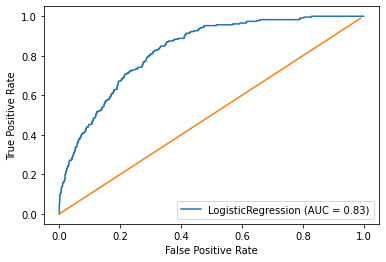

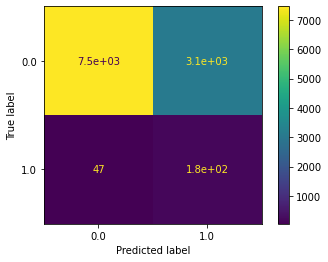

In [372]:
lr.fit(X_train_full, y_train_full)
get_metrics(lr, X_test_full, y_test_full)

In [373]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, random_state=6, stratify=y,
                                                                       test_size=0.25)

In [374]:
X_train_full = X_train_full.append(df_rej.drop(['prob_rej', 'prob_rej_cut', 'target'], axis=1).reset_index(drop=True))
y_train_full = y_train_full.append(df_rej['target'].reset_index(drop=True))

GINI: 0.6355939418865582
F : 0.10095098756400879


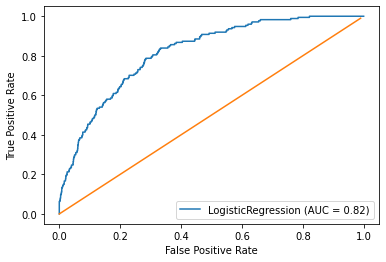

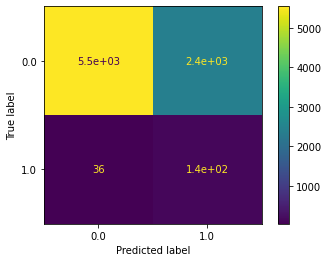

In [375]:
lr.fit(X_train_full, y_train_full)
get_metrics(lr, X_test_full, y_test_full)